In [3]:
#!pip install holidays
!pip install python-geohash


In [18]:
import os, sys
from pathlib import Path
import pickle
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import holidays
import Geohash as gh
#import pygeohash as gh
import matplotlib.pyplot as plt
import datetime 
from dp_utils import *
from sklearn.ensemble import RandomForestClassifier as RFC
import eli5
from eli5.sklearn import PermutationImportance 
#plt.style.use(['dark_background'])   # This notebook was written in Jupyter-lab with dark-theme 

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = dataset_to_user_dict(dataset, userFiles)   

In [21]:
userTrips[userFiles[0]].values.shape

(684, 11)

# Data processing/pipeline

In [28]:
%%time
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = dataset_to_user_dict(dataset, userFiles)   
lastMonth = getLastMonth(userFiles, userTrips)        
dropList  = ['id','start_timezone', 'end_timezone']; userTrips = drop_cols(userFiles, userTrips, dropList) 
# -----------------------------------------------------------
precision = 6
prc_dict  = {5: 2400 , 6: 610 , 7: 76 , 8: 19} # meters
userTrips = addGeohash(userFiles, userTrips, precision = precision) 
# -----------------------------------------------------------
userTrips = unifyLatLon(userFiles,userTrips)
userTrips = addTripDur(userFiles, userTrips)          
userTrips = addTripDis(userFiles, userTrips)    
userTrips = addLastTripDisDir(userFiles, userTrips, dis=True, dur=True)
userTrips = addEndToStartDis(userFiles, userTrips)
userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance= (precision-100)/1000)
userTrips = addEndToStartDur(userFiles, userTrips)
userTrips = addSameDay(userFiles, userTrips)
userTrips = addStartGeoRank(userFiles, userTrips)
userTrips = addEndGeoRank(userFiles, userTrips)
userTrips = addDisToTopStartGeos(userFiles, userTrips, n_most_freq = 3)
userTrips = addDisToTopEndGeos(userFiles, userTrips, n_most_freq = 3)
userTrips = addDatetimeFeatures(userFiles, userTrips)
userTrips = addGeohashClasses(userFiles, userTrips)
# ==============================================================
dropList = ['start_time', 'end_time', 'start_location_lat', 'start_location_lon', 'start_location_name', 'end_location_lat',
 'end_location_lon', 'end_location_name','start_location_geohash', 'end_location_geohash', 'tripDur_min', 'tripDis_Km','end_location_freq']#+\
'''
['dis_to_start_geo_9_Km', 'is_holiday', 'night',
'dis_to_end_geo_6_Km', 'dis_to_end_geo_2_Km',
'dis_to_end_geo_3_Km', 'dis_to_start_geo_3_Km', 'endToStartDis_Km',
'dis_to_start_geo_6_Km', 'dis_to_start_geo_4_Km',
'dis_to_start_geo_7_Km', 'dis_to_start_geo_5_Km',
'dis_to_end_geo_8_Km', 'dis_to_start_geo_2_Km',
'dis_to_end_geo_4_Km', 'endToStartDur_min', 'dis_to_end_geo_10_Km',
'is_sameDay', 'start_location_freq', 'afternoon',
'dis_to_start_geo_8_Km', 'dis_to_end_geo_5_Km', 'lastTripDur_min',
'evening', 'morning', 'dis_to_end_geo_1_Km',
'dis_to_start_geo_1_Km'
   ] 
'''
userTrips = drop_cols(userFiles, userTrips, dropList)
# =============================================================
userTrains, userValids = train_val_split(userFiles, userTrips, lastmonth= 5)

Wall time: 962 ms


In [30]:
df = userTrains[userFiles[0]]
df.columns

Index(['lastTripDis_Km', 'lastTripDur_min', 'endToStartDis_Km',
       'endToStartDur_min', 'is_sameDay', 'start_location_freq',
       'dis_to_start_geo_1_Km', 'dis_to_start_geo_2_Km',
       'dis_to_start_geo_3_Km', 'dis_to_end_geo_1_Km', 'dis_to_end_geo_2_Km',
       'dis_to_end_geo_3_Km', 'hour_of_day', 'night', 'morning', 'afternoon',
       'evening', 'day_of_week', 'is_weekend', 'is_holiday', 'day_of_month',
       'month_of_year', 'start_class', 'end_class'],
      dtype='object')

# List of feartures used for ML training and validation 

In [23]:
userTrains[userFiles[0]].columns.tolist()[:-1]

['lastTripDis_Km',
 'dis_to_start_geo_10_Km',
 'dis_to_end_geo_7_Km',
 'dis_to_end_geo_9_Km',
 'hour_of_day',
 'day_of_week',
 'is_weekend',
 'day_of_month',
 'month_of_year',
 'start_class']

# Model training and valdiation

In [36]:
%%time 
# Set Up random forest model 
RFparams = {'n_estimators'    : 500,
            'min_samples_leaf': 3, 
            'n_jobs'          : -1,
            'random_state'    : 42,
            'max_features'    : 0.4,
             }
model  = RFC().set_params(**RFparams)


for user in userFiles: 
    model_fitted = model.fit(userTrains[user].iloc[:,:-1], userTrains[user].iloc[: ,-1])
    
    
    # Save each user's trained model --------------------------------
    with open(f'{user}_trained_model.pkl', 'wb') as handle:     
        pickle.dump(model_fitted, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # ----------------------------------------------------------------
    
    pred_true    = [(start,y_true,y_pred,round(prob,2)) for start, y_true,y_pred,prob in\
                    zip(userValids[user]['start_class'] , userValids[user]['end_class'] , model_fitted.predict(userValids[user].iloc[:,:-1]), np.max(model_fitted.predict_proba(userValids[user].iloc[:,:-1]), axis=1 ))  ]
    #right        = [(s,i,j,p) for s,i,j,p in pred_true if i==j] 
    #wrong        = [(s,i,j,p) for s,i,j,p in pred_true if i!=j]
    accuracy     = round((1 -  sum([1 for s,i,j,p in pred_true if i!=j ]) / len(pred_true)) * 100,2)
    print('-', user , f' Prediction Accuracy (with +/- ~ {prc_dict[precision]}m precision) : ', accuracy, '%')
    # --------------------------------------------------------------------------------------------------------


- userA_trips  Prediction Accuracy (with +/- ~ 610m precision) :  43.26 %
- userB_trips  Prediction Accuracy (with +/- ~ 610m precision) :  70.63 %
- userC_trips  Prediction Accuracy (with +/- ~ 610m precision) :  50.0 %
- userD_trips  Prediction Accuracy (with +/- ~ 610m precision) :  47.52 %
CPU times: user 5.91 s, sys: 82.5 ms, total: 5.99 s
Wall time: 7.24 s


In [40]:
add = imp_eli5['Feature'][8:].values

# Permutation importance

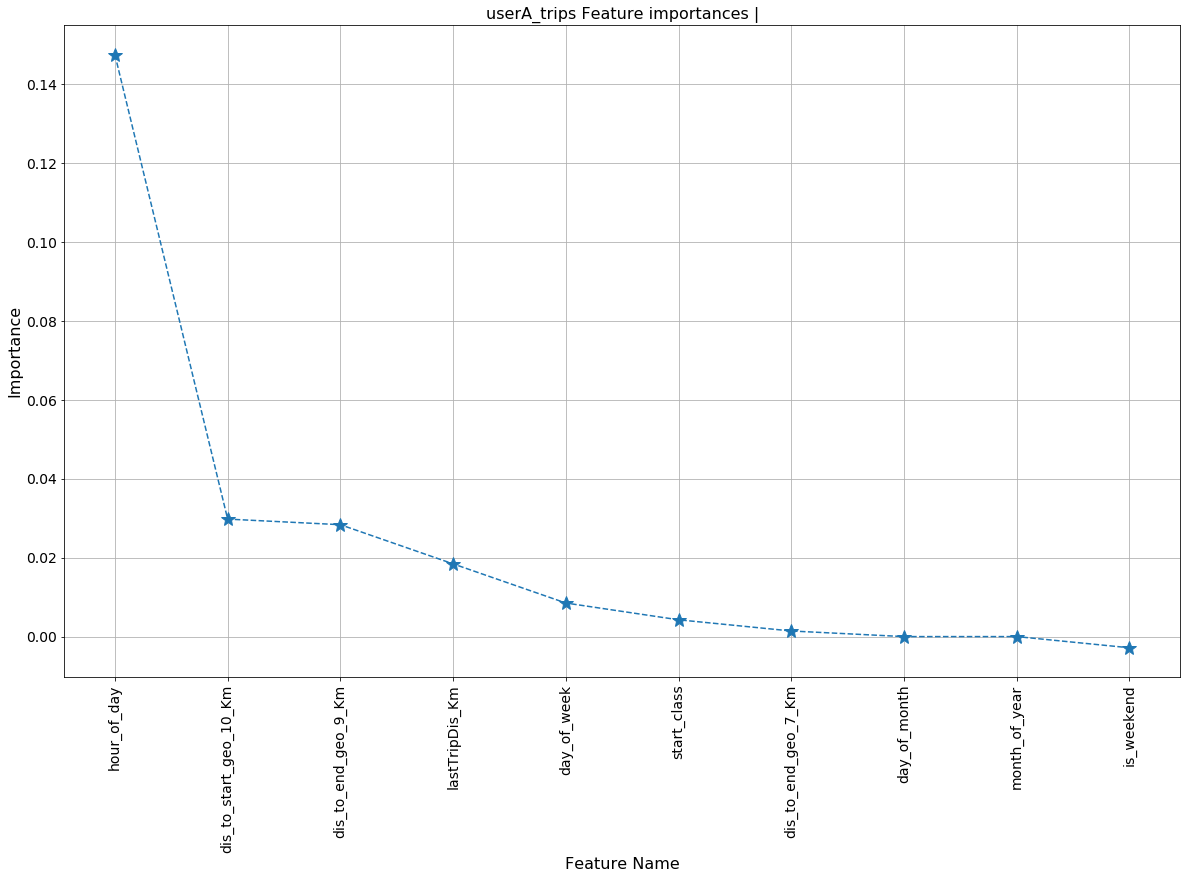

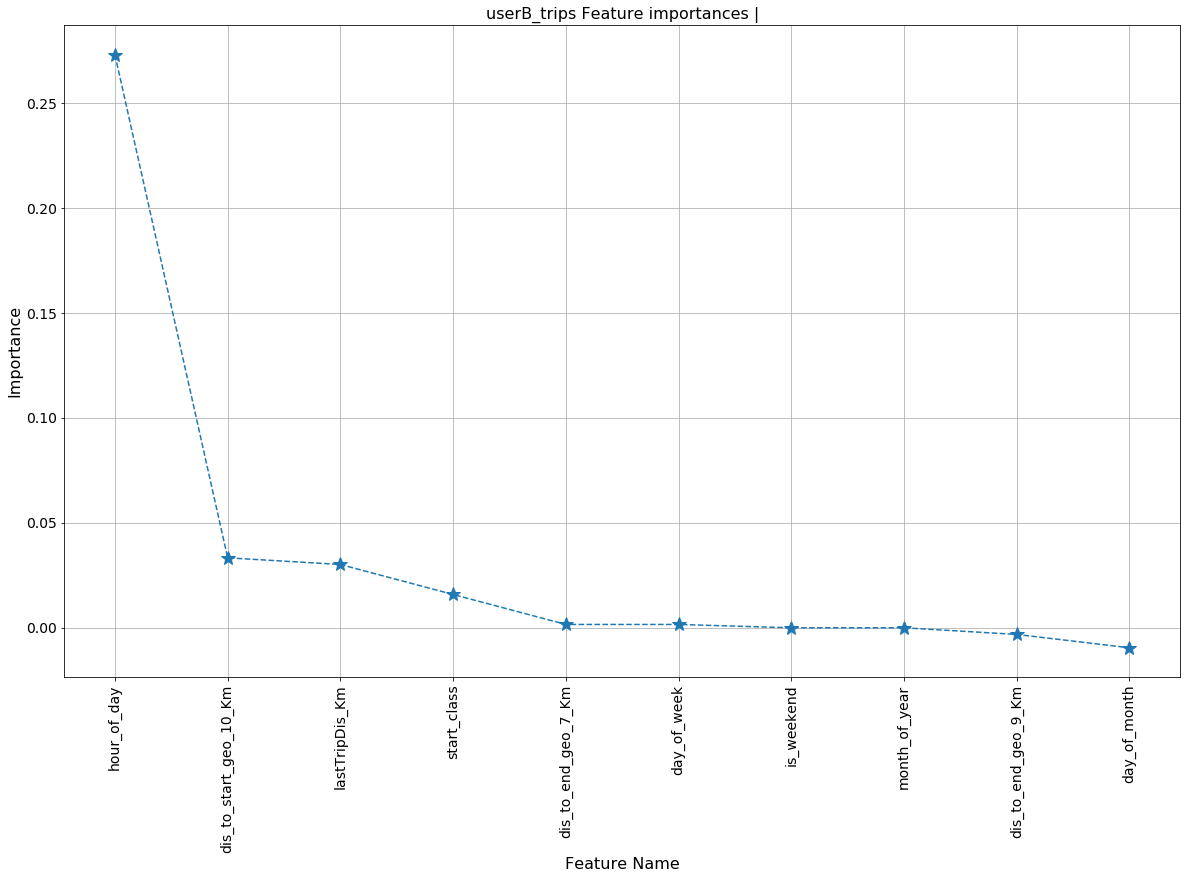

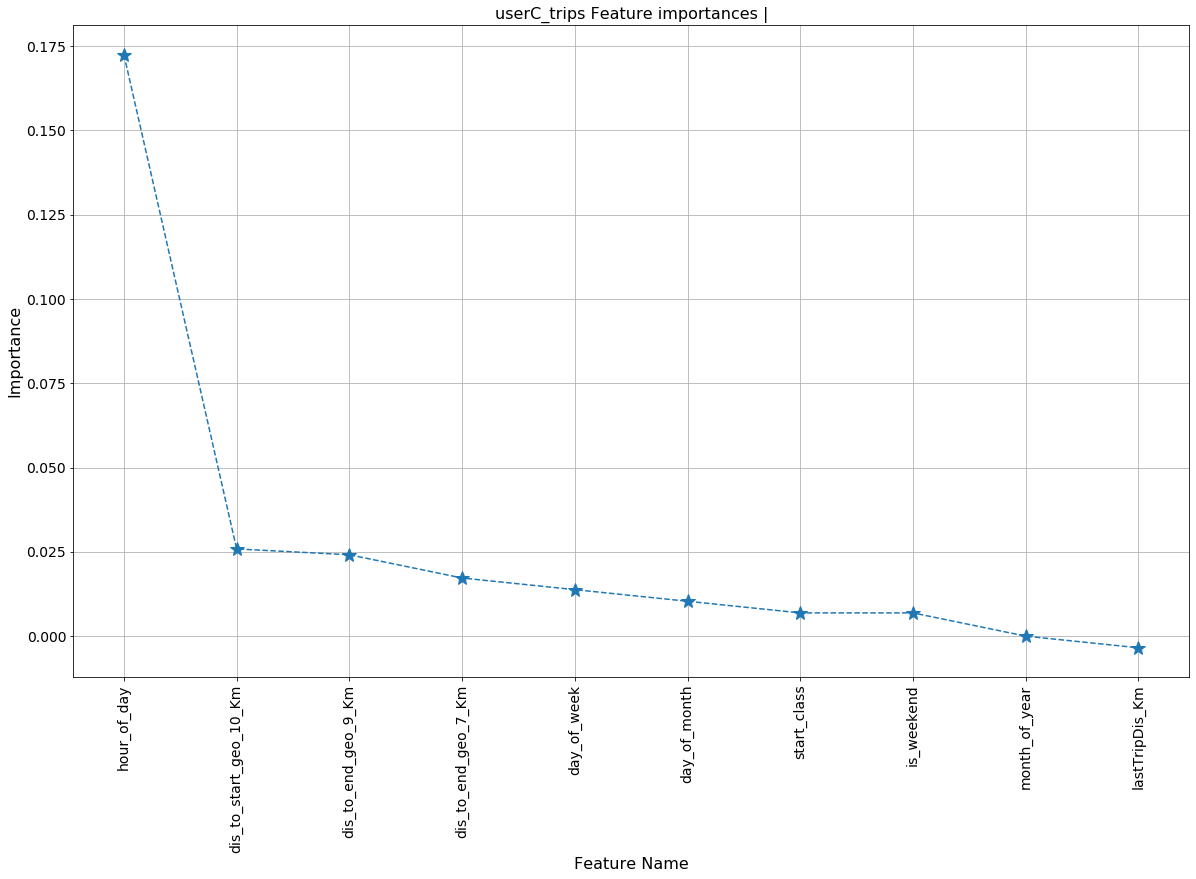

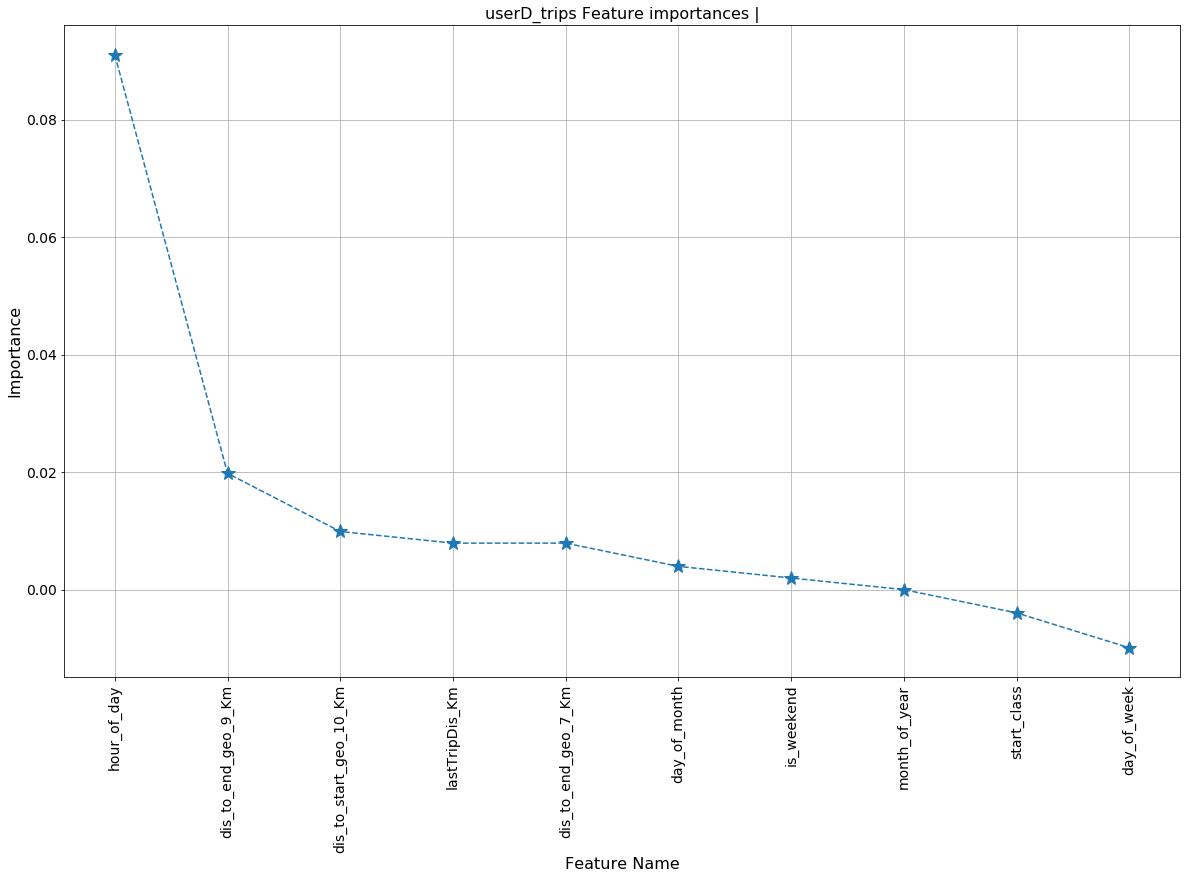

In [33]:
for user in userFiles: 
    
    # Load each user's trained model ----------------------
    with open(f'{user}_trained_model.pkl', 'rb') as handle:    
        model_fitted = pickle.load(handle)    
    # -----------------------------------------------------

    imp_eli5 = pd.DataFrame(columns = ['Feature', 'Importance'])
    perm     = PermutationImportance(model_fitted, scoring='accuracy').fit(userValids[user].iloc[:,:-1], userValids[user]['end_class'])
    imp_eli5 = imp_eli5.append(pd.DataFrame(list(zip(list(userTrains[user].columns[:-1]), perm.feature_importances_)), columns=['Feature', 'Importance']) )
    imp_eli5 = imp_eli5.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(20,12))
    plt.plot(imp_eli5.Feature, imp_eli5.Importance,'--*', markersize=14)
    plt.xticks(rotation=90)
    plt.title(user + ' Feature importances |', fontsize=16)
    plt.xlabel('Feature Name', fontsize=16)    
    plt.ylabel('Importance', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.grid()  
    plt.show()


# Results Summary
    - userA_trips  Prediction Accuracy (with +/- ~ 2400m precision) :  96.45 %
    - userB_trips  Prediction Accuracy (with +/- ~ 2400m precision) :  91.27 %
    - userC_trips  Prediction Accuracy (with +/- ~ 2400m precision) :  94.83 %
    - userD_trips  Prediction Accuracy (with +/- ~ 2400m precision) :  91.09 %
    ===========================================================================
    - userA_trips  Prediction Accuracy (with +/- ~ 610m precision) :  94.33 %
    - userB_trips  Prediction Accuracy (with +/- ~ 610m precision) :  88.89 %
    - userC_trips  Prediction Accuracy (with +/- ~ 610m precision) :  93.1 %
    - userD_trips  Prediction Accuracy (with +/- ~ 610m precision) :  84.16 %
    ===========================================================================
    - userA_trips  Prediction Accuracy (with +/- ~ 76m precision) :  88.65 %
    - userB_trips  Prediction Accuracy (with +/- ~ 76m precision) :  85.71 %
    - userC_trips  Prediction Accuracy (with +/- ~ 76m precision) :  82.76 %
    - userD_trips  Prediction Accuracy (with +/- ~ 76m precision) :  78.22 %
    ===========================================================================
    - userA_trips  Prediction Accuracy (with +/- ~ 19m precision) :  83.69 %
    - userB_trips  Prediction Accuracy (with +/- ~ 19m precision) :  84.92 %
    - userC_trips  Prediction Accuracy (with +/- ~ 19m precision) :  78.45 %
    - userD_trips  Prediction Accuracy (with +/- ~ 19m precision) :  72.28 %